# Problem Set 2
## Dawei Wang (dwang56)
## Problem 1

In [112]:
import matplotlib.pyplot as plt
import matplotlib.ticker
from scipy import stats, signal
from scipy.io import wavfile
import numpy as np
import warnings
import math
import sys

## Spectrogram

In [113]:
def read_wav(file):
    fs, data = wavfile.read(file)
    data = data.astype('float32') / np.power(2, 15)
    print("The magnitude of spectrogram is: ", data.shape[0])
    return fs, data

def generate_spectrogram(fs, data, window_size, overlap):
    # generate spectrogram matrix with hamming window applied
    f, t, Sxx = signal.spectrogram(data, fs, window = signal.get_window('hamming',window_size), nperseg = window_size, noverlap= overlap, scaling='spectrum')
    
    # calculate sqrt for better visualization
    Sxxsq = np.sqrt(np.abs(Sxx))
    
    # plot spectorgram
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    im = plt.pcolormesh(t, f, Sxxsq, vmin=0, vmax = 1e-2)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    fig.colorbar(im)
    plt.show()
    
    # return original spectrogram
    return f, t, Sxx

The magnitude of spectrogram is:  88973


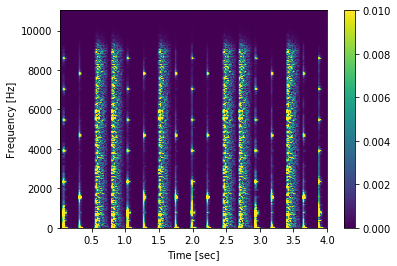

In [114]:
file = "./vl1.wav"
WINDOW_SIZE = 1024
OVERLAP = 0.75 * WINDOW_SIZE
N_COMPONENTS = 3

fs, data = read_wav(file)
f, t, S = generate_spectrogram(fs, data, WINDOW_SIZE, OVERLAP)

## PCA & ICA & NMF

In [115]:
def plot_signal(W, Z, f, t, method):
    # plot weight
    f1, ax1 = plt.subplots(nrows = 3, ncols = 1, figsize=(6, 6))
    
    for i in range(0, 3):
        ax1[i].plot(t, W[:,i]) 
        ax1[i].set_xlabel('Time / s')
        ax1[i].set_title('Feature ' + str(i+1))
        
    f1.suptitle(method + ' Weights', x = 0.5, y = 1.05)  
    f1.tight_layout()
    
    # plot components
    f2, ax2 = plt.subplots(nrows = 1, ncols = 3, figsize=(6, 6))
    
    for i in range(0, 3):
        ax2[i].plot(Z[:,i], f)
        ax2[i].set_ylabel('Frequency / Hz')
        ax2[i].set_title('Feature ' + str(i+1))
    
    f2.suptitle(method + ' Features', x = 0.5, y = 1.05)  
    f2.tight_layout()

def pca(X, n_components):
    # calculate mean over feature dimension
    X -= np.mean(X, axis=1)[:, np.newaxis]
    
    # singular value decomposition
    U, S, V = np.linalg.svd(X, full_matrices = False)
    
    # compute weight & features
    S = np.linalg.inv(np.diag(np.sqrt(S[:n_components])))
    Z = S.dot(U[:, :n_components].T)
    W = Z @ X
    
    return W.T, Z.T  

def ica(X, Z_p, epochs = 500, lr = 1e-4):
    k, N = X.shape

    W_i = np.identity(k, dtype = np.float32)
    I = np.identity(k)
    
    for i in range(epochs):
        y = W_i @ X
        delta = (N * I - 2 * np.tanh(y) @ y.T) @ W_i
        W_i += lr * delta

    W_mix = (W_i @ X).T
    Z_i = np.linalg.pinv(W_i @ Z_p)
    return W_mix, Z_i

def nmf(X, n_components, epochs = 500, eps=1e-6):
    d, n = X.shape
    X[X < 0] = 0
    W = np.random.rand(d, n_components)
    H = np.random.rand(n_components, n)
    
    for i in range(epochs):
        XH = X.dot(H.T)
        WH = W.dot(H.dot(H.T))
        W = W * XH / (WH + eps)
        WX = W.T @ X
        WWH = W.T @ (W @ H)
        H = H * WX / (WWH + eps)
    
    return H.T, W 

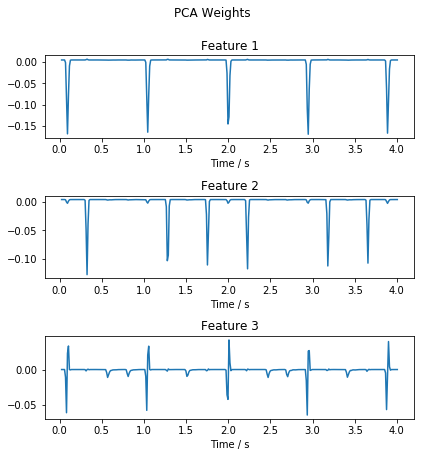

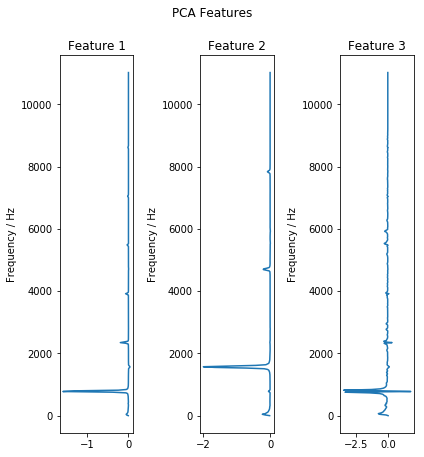

In [116]:
# compute PCA
W_p, Z_p = pca(S, N_COMPONENTS)
plot_signal(W_p, Z_p, f, t, 'PCA')

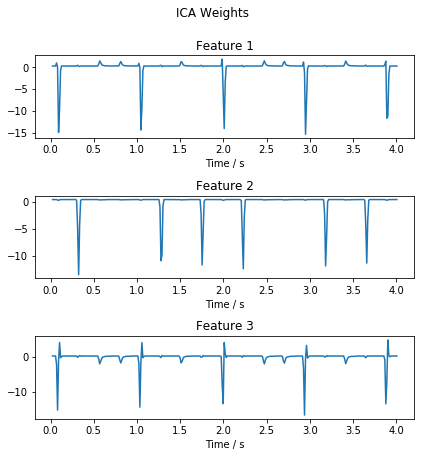

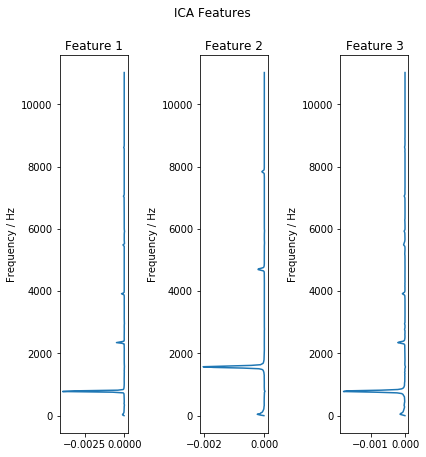

In [117]:
# compute ICA
W_mix, Z_i = ica(W_p.T, Z_p.T)
plot_signal(W_mix, Z_i, f, t, 'ICA')

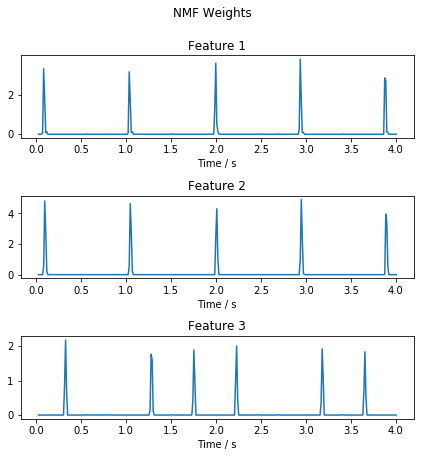

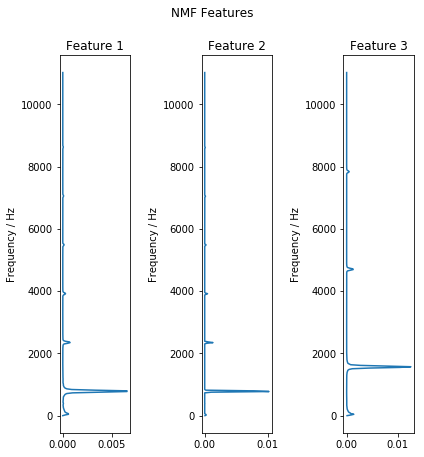

In [118]:
W_n, Z_n = nmf(S, N_COMPONENTS)
plot_signal(W_n, Z_n, f, t, 'NMF')

## Observation & Conclusion
For both weights and features, PCA, ICA, NMF have similar pattern and we can easily distinguish the 3 instruments. However, there are still differences between these methods. First, PCA & ICA have both positive and negative weights and features but NMF only has non-negative part. Second, compared with PCA, ICA weights are more independent especially for component 3 in my figure.

I believe ICA makes the most sense. From the output image, we can see sometimes there are some small noises between two strong peaks for PCA and NMF. Instead, pattern generated by ICA is much clean. Theoretically speaking, both PCA and NMF focus on finding which is the one that best explains the variability of our data but ICA finds independent components in our data. In our case, as we have only have 3 clear different kinds of sound, using ICA can better explain our data.

## Problem 2
### Load data

In [119]:
def data_loader(file):
    # extract data & label
    npz = np.load(file)
    data = npz['d.npy']
    label = npz['l.npy']
    
    d, n = data.shape
    
    f = plt.figure()
    for i in range(36):
        ax = f.add_subplot(6, 6, i + 1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(np.reshape(data[:,i],(28,28),'F'))
    
    return data, label

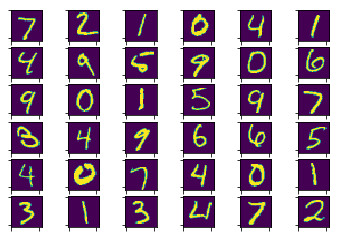

In [120]:
file = "digits-labels.npz"
N_COMPONENTS = 36

X, L = data_loader(file)

## PCA & ICA & NMF

In [121]:
def plot_figure(X, n_components = 36, method = 'PCA'):
    # plot PCA components
    f = plt.figure()
    for i in range(n_components):
        ax = f.add_subplot(6, 6, i + 1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_facecolor('w')
        ax.imshow(np.reshape(X[:,i],(28,28),'F'))
    f.suptitle(method + ' features')

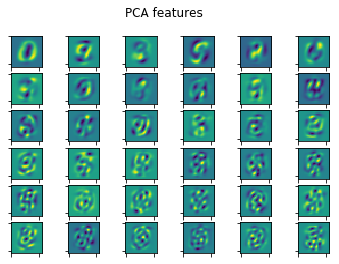

In [122]:
# compute PCA
W_p, Z_p = pca(X, N_COMPONENTS)
plot_figure(Z_p, method = 'PCA')

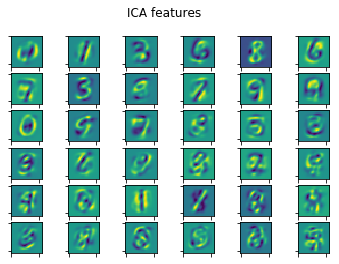

In [123]:
# compute ICA
W_mix, Z_i = ica(W_p.T, Z_p.T, N_COMPONENTS)
plot_figure(Z_i, method = 'ICA')

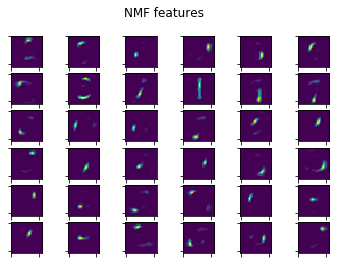

In [124]:
# compute NMF
W_n, Z_n = nmf(X, N_COMPONENTS)
plot_figure(Z_n, method = 'NMF')

## Observation & Conclusion
From observation, we can see that PCA and ICA looks similar to each other but NMF produces features very differently. This is because PCA and ICA have both negative and positive components where NMF only contain non-negative terms. Another observation we can see is ICA produces feature more clearly than PCA. The reason for it is that our input data is 10000 images of handwritten digits. Though people write some numbers differently, we decide to analyze the data within 36 dimensions. As output dimension(36) is greatly smaller than input dimension(10000), the input data is sparse which makes ICA works better than PCA.

## Problem 3
### Load data

In [125]:
# Get digit six
X_6 = X[:, L==6]
N_COMPONENTS = 2

In [129]:
from scipy.sparse.csgraph import floyd_warshall

def plot_scatter(W, X, method, s = 2):
    f, ax = plt.subplots(figsize=(6, 6))
    f.suptitle(method + ' 2D scatter plot', y = 0.95)

    scale = min(max(W[:,0]) - min(W[:,0]), max(W[:,1]) - min(W[:,1])) / 10
    ax.set_xlim([min(W[:,0]), max(W[:,0]) + scale])
    ax.set_ylim([min(W[:,1]), max(W[:,1]) + scale])

    for i in range(0, X.shape[1], s):
        ax.imshow(np.reshape(X[:,i], (28,28), 'F'), interpolation='none', extent=[W[i, 0], W[i, 0] + scale, W[i, 1], W[i, 1] + scale])

def isomap(X, n_components, k_neighbors = 6):
    # Get distance matrix
    d, n = X.shape
    D = np.outer(np.diagonal(X.T @ X), np.ones(n)) + np.outer(np.ones(n).T, np.diagonal(X.T @ X).T) - 2*(X.T @ X)
    
    # only interested in k nearest neighbors
    for i in range(n):
        invalid = np.argsort(D[i])
        D[i, invalid[k_neighbors+1:]] = np.Inf 
    D = np.minimum(D, D.T)

    # Floyd's algorithm
    D = floyd_warshall(D)
    
    # eigen decomposition
    I = np.outer(np.ones(n).T, np.ones(n))
    D = -0.5 * (D - 1 / n * D @ I - 1 / n * I @ D + 1 / np.power(n, 2) * I @ (D @ I))
    
    W, V = np.linalg.eig(D)
    idx = np.argsort(W)[::-1]
    W_iso = V[:, idx[:n_components]]
    
    return W_iso

## PCA & ISOMAP

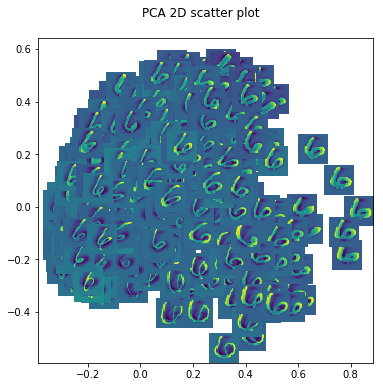

In [130]:
# compute PCA
W_p, Z_p = pca(X_6, N_COMPONENTS)
plot_scatter(W_p, X_6, 'PCA')

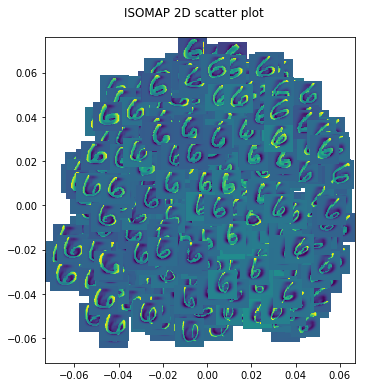

In [131]:
# isomap
W_iso = isomap(X_6, N_COMPONENTS)
plot_scatter(W_iso, X_6, 'ISOMAP')

## Observation & Conclusion
For both scatter plot using PCA and ISOMAP, we can see clearly that sixes with the same direction and thickness are tend to gathered together. Also from one side to the other side of the images, the direction and thickness of sixes changes gradually. However, there are some sudden changes for the direction of sixes in PCA image(i.e. position (0.4, -0.1)). In contrast, the direction of sixes changes more smoothly in ISOMAP image.